# Zillow: Predicting Logerror


Presented By: Kristine Cabanela, David Rodriguez

January 13, 2021


# Project Goal

- In this project, our overall goal is to identify key drivers of logerror for single family properties in the Zillow dataset. The focus will be the single unit properties that had a transaction during 2017.


### Imports

In [5]:
# Below are imports of python modules and/or libraries necessary for analysis
import pandas as pd
import env
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
import wrangle
import warnings
warnings.filterwarnings('ignore')

# Acquire and Prep - Wrangle

### Get data by creating a function that connects to the SQL server
- Acquire data by using a SQL query to Zillow table in the mySQL database.


In [6]:
# Acquired dataset from stored module and assigned as df

df = wrangle.get_zillow()
df.head()


,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror
0,1727539,14297519,NaN,NaN,NaN,3.5,4.0,None,NaN,3.5,...,NaN,485713.0,1023282.0,2016.0,537569.0,11013.72,None,NaN,6.059063e+13,0.025595
1,1387261,17052889,NaN,NaN,NaN,1.0,2.0,None,NaN,1.0,...,NaN,88000.0,464000.0,2016.0,376000.0,5672.48,None,NaN,6.111001e+13,0.055619
2,11677,14186244,NaN,NaN,NaN,2.0,3.0,None,NaN,2.0,...,NaN,85289.0,564778.0,2016.0,479489.0,6488.30,None,NaN,6.059022e+13,0.005383
3,2288172,12177905,NaN,NaN,NaN,3.0,4.0,None,8.0,3.0,...,NaN,108918.0,145143.0,2016.0,36225.0,1777.51,None,NaN,6.037300e+13,-0.103410
4,781532,12095076,1.0,NaN,NaN,3.0,4.0,None,9.0,3.0,...,NaN,276684.0,773303.0,2016.0,496619.0,9516.26,None,NaN,6.037461e+13,-0.001011


In [7]:
# There are 52441 columns and 60 rows in this dataset

df.shape

(52441, 60)

# Prepare
### Perform a data cleanup:
- To ensure that the data we are evaluating is at a high quality meaning it is free of incorrect, irrelevant, or incomplete information which will minimize the risk of wrong or inaccurate conclusions.

## Steps

- After aquiring dataset using a SQL query to Zillow table in the mySQL database, we looked at an overall overview of the dataset by looking at the number of columns and rows, whether any columns had null values and how many, and what the datatypes were for said columns so that we can familiarize ourselves with the dataset.
- With review of the dataset, there were are a significant amount of null values found in more than half our columns
- Firstly, we went ahead and dropped columns with missing values greater than 20%
- We removed the rest of the null values and confirmed there are now 0 nulls. 
- Next, we dropped the following columns: id, parcelid, propertycountylandusecode, regionidcity, regionidcounty, finishedsquarefeet12, fullbathcnt, calculatedbathnbr, and assessmentyear as they were insignificant to logerror
- We've found some outliers and we will drop those too
- Created a new column using fips to show column for counties
- After data cleanup a function was created for updated prepped Zillow data

## Takeaways
- Original dataset 52,441 columns and 60 rows in this dataset
- More than half of the columns were dropped because more than 50% of the column had null values.
- After prepping original acquired dataset, we are left with 47,897 columns and 17 rows in this dataset

In [205]:
# Displayed is our already prepped dataset 

wrangle_zillow = wrangle.wrangle_zillow()
wrangle_zillow.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidzip,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,county
0,3.5,4.0,3100.0,33634931.0,-117869207.0,4506.0,6.059063e+07,96978.0,0.0,1998.0,485713.0,1023282.0,537569.0,11013.72,6.059063e+13,0.025595,Orange
2,2.0,3.0,1243.0,33886168.0,-117823170.0,8432.0,6.059022e+07,97078.0,6.0,1962.0,85289.0,564778.0,479489.0,6488.30,6.059022e+13,0.005383,Orange
3,3.0,4.0,2376.0,34245180.0,-118240722.0,13038.0,6.037300e+07,96330.0,0.0,1970.0,108918.0,145143.0,36225.0,1777.51,6.037300e+13,-0.103410,Los_Angeles
4,3.0,4.0,2962.0,34145202.0,-118179824.0,63000.0,6.037461e+07,96293.0,0.0,1950.0,276684.0,773303.0,496619.0,9516.26,6.037461e+13,-0.001011,Los_Angeles
5,1.0,2.0,738.0,34149214.0,-118239357.0,4214.0,6.037302e+07,96325.0,0.0,1922.0,18890.0,218552.0,199662.0,2366.08,6.037302e+13,0.101723,Los_Angeles


In [9]:
wrangle_zillow.shape

(47897, 17)

In [16]:
wrangle_zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47897 entries, 0 to 52440
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   47897 non-null  float64
 1   bedroomcnt                    47897 non-null  float64
 2   calculatedfinishedsquarefeet  47897 non-null  float64
 3   latitude                      47897 non-null  float64
 4   longitude                     47897 non-null  float64
 5   lotsizesquarefeet             47897 non-null  float64
 6   rawcensustractandblock        47897 non-null  float64
 7   regionidzip                   47897 non-null  float64
 8   roomcnt                       47897 non-null  float64
 9   yearbuilt                     47897 non-null  float64
 10  structuretaxvaluedollarcnt    47897 non-null  float64
 11  taxvaluedollarcnt             47897 non-null  float64
 12  landtaxvaluedollarcnt         47897 non-null  float64
 13  t

# Let's split our data

In [206]:
# 20% test, 80% train_validate
# then of the 80% train_validate: 30% validate, 70% train.

train, test = train_test_split(wrangle_zillow, test_size = .2, random_state = 123)
train, validate = train_test_split(train, test_size = .3, random_state = 123)

In [85]:
# Validate my split.

print(f'train -> {train.shape}')
print(f'validate -> {validate.shape}')
print(f'test -> {test.shape}')

train -> (26821, 17)
validate -> (11496, 17)
test -> (9580, 17)


In [207]:
# Function created to split dataset

def split_data(df):
    '''
    take in a DataFrame and return train, validate, and test DataFrames
    return train, validate, test DataFrames.
    '''
    train, test = train_test_split(wrangle_zillow, test_size = .2, random_state = 123)
    train, validate = train_test_split(train, test_size = .3, random_state = 123)
    
    return train, validate, test

In [208]:
# apply split_data function to dataset

train, validate, test = split_data(wrangle_zillow)

In [88]:
# Validate my split.

print(f'train -> {train.shape}')
print(f'validate -> {validate.shape}')
print(f'test -> {test.shape}')

train -> (26821, 17)
validate -> (11496, 17)
test -> (9580, 17)


In [89]:
# Rows and columns for train, validate, and test

train.shape, validate.shape, test.shape

((26821, 17), (11496, 17), (9580, 17))

# Explore

### Initial Questions

- Is there a relationship between logerror and longitude and latitude?

- Is there a relationship between bedroom count and logerror?
    
- Is there a relationship between square feet and logerror?

- How different are the logerrors for the three counties in the dataset?

### Question 1
**Is there a relationship between logerror and longitude and latitude?**

In [17]:
train_cluster = train[['latitude', 'longitude']]
X = train_cluster
kmeans = KMeans(n_clusters = 6)
kmeans.fit(X)
train_cluster['cluster'] = kmeans.predict(X)
centroids = pd.DataFrame(kmeans.cluster_centers_, columns = ['latitude', 'longitude'])
train_cluster.groupby('cluster')['latitude', 'longitude'].mean()

,latitude,longitude
cluster,,
0,3.423269e+07,-1.189727e+08
1,3.393781e+07,-1.179268e+08
2,3.462804e+07,-1.181245e+08
3,3.363089e+07,-1.177652e+08
4,3.395188e+07,-1.182375e+08
5,3.421416e+07,-1.184768e+08


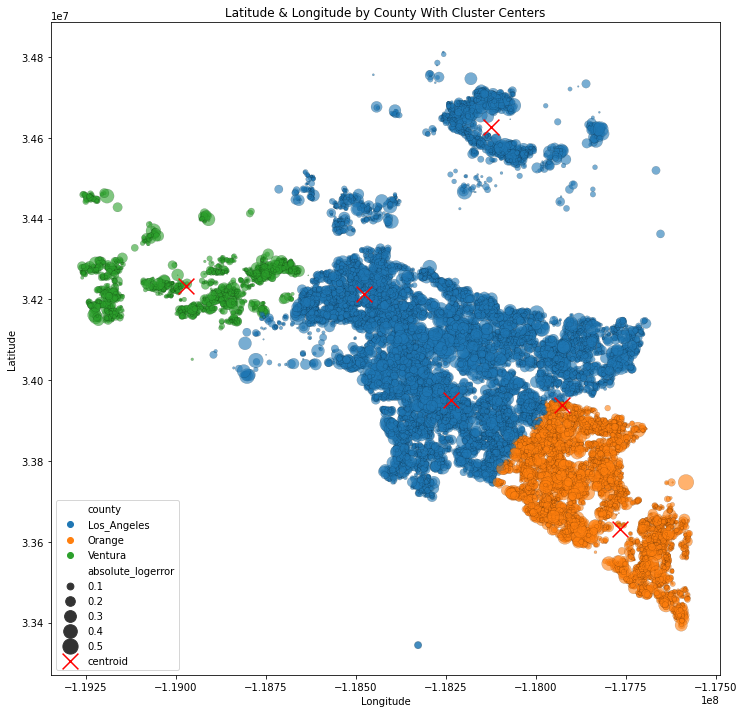

In [22]:
# Plot the data

train['absolute_logerror'] = abs(train['logerror'])
plt.figure(figsize = (12, 12))
sns.scatterplot(x = 'longitude', y = 'latitude', hue = 'county', data = train, ec = 'black', linewidth = 0.15, alpha = 0.6, size = 'absolute_logerror', sizes = (0, 250))
centroids.plot.scatter(x = 'longitude', y = 'latitude', c = 'red', marker = 'x', s = 250, ax = plt.gca(), label = 'centroid')

plt.legend()
plt.title('Latitude & Longitude by County With Cluster Centers')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
train.drop(columns = ['absolute_logerror'], inplace = True)

### Takeaways

- The use of absolute value for logerror vs actual numbers help with the sizing of the clusters.
    - additionally, might be worth looking into analyzing abs logerror vs natural logerror as abs logerror represents how off the estimate was vs whether the amount predicted was under or over the final sale price.
- The majority of errors follows dataset population: LA then Orange, then Ventura
- There seems to be bigger logerror concentrations in LA compared to the other two counties but it might be because there's more datapoints in LA.
- There isn't a clear relationship between logerror and latitude and longitude

### Question 2
**What is the relationship between the number of rooms a home has and logerror?**

In [14]:
# View how many of each for bedroom count

train.bedroomcnt.value_counts()

3.0    12462
4.0     7933
2.0     4250
5.0     1694
1.0      275
6.0      207
Name: bedroomcnt, dtype: int64

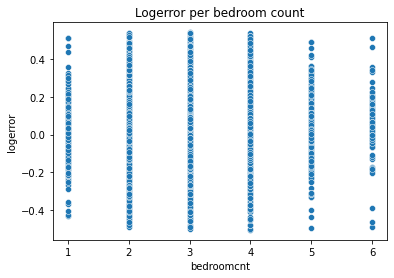

In [17]:
sns.scatterplot(x = 'bedroomcnt', y ='logerror', data = train)
plt.title('Logerror per bedroom count')
plt.xlabel('bedroomcnt') 
plt.ylabel('logerror')
plt.show()

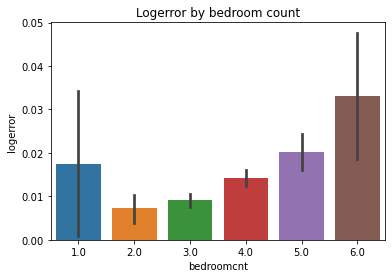

In [54]:
sns.barplot(x = 'bedroomcnt', y = train.logerror, data = train)
plt.title('Logerror by bedroom count')
plt.show()

#### ANOVA Statistical Test: comparing means of logerror by room

**Set Hypothesis**

$H_{0}$: The logerror for properties with X number of rooms is not different from the population logerror.

$H_{a}$: The logerror for properties with X number of rooms is  different from the population logerror.

**Verify Assumptions**
 - Normal Distribution? **yes**
 - Independent Samples? **yes**
 - Equal Variances? **yes**

In [23]:
one_b = train[train.bedroomcnt == 1.0].logerror
two_b = train[train.bedroomcnt == 2.0].logerror
three_b = train[train.bedroomcnt == 3.0].logerror
four_b = train[train.bedroomcnt == 4.0].logerror
five_b = train[train.bedroomcnt == 5.0].logerror
six_b = train[train.bedroomcnt == 6.0].logerror

#### Normal Distribution Check

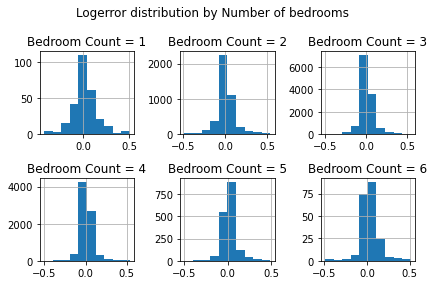

In [32]:
plt.suptitle('Logerror distribution by Number of bedrooms')
plt.subplot(2, 3, 1)
plt.title('Bedroom Count = 1')
one_b.hist()
plt.subplot(2, 3, 2)
plt.title('Bedroom Count = 2')
two_b.hist()
plt.subplot(2, 3, 3)
plt.title('Bedroom Count = 3')
three_b.hist()
plt.subplot(2, 3, 4)
plt.title('Bedroom Count = 4')
four_b.hist()
plt.subplot(2, 3, 5)
plt.title('Bedroom Count = 5')
five_b.hist()
plt.subplot(2, 3, 6)
plt.title('Bedroom Count = 6')
six_b.hist()
plt.tight_layout();

#### Equal Variance Check

In [35]:
print('Variance values by bedroom Count:')
print('Bedroom count = 1: ', one_b.var())
print('Bedroom count = 2: ', two_b.var())
print('Bedroom count = 3: ', three_b.var())
print('Bedroom count = 4: ', four_b.var())
print('Bedroom count = 5: ', five_b.var())
print('Bedroom count = 6: ', six_b.var())

Variance values by bedroom Count:
Bedroom count = 1:  0.018124791717918563
Bedroom count = 2:  0.012272244704164138
Bedroom count = 3:  0.008086138506228866
Bedroom count = 4:  0.0072449168569474675
Bedroom count = 5:  0.0071794637385562896
Bedroom count = 6:  0.01273258949110612


In [38]:
f, p = stats.f_oneway(one_b, two_b, three_b, four_b, five_b, six_b)
print(f, p)

alpha = 0.05

print('')

if p < alpha:
    print("We reject $H_{0}$")
else:
    print("We fail to reject $H_{0}$")

10.184764428983895 9.159409201931749e-10

We reject $H_{0}$


#### Takeaways
 - While it looked like logerror was pretty similar for homes with bedroom counts = 2 through 4, as shown on the scatterplot, the barplot shows that actually logerrors are lowestfor homes with bedroom counts = 2 through 4.
 - The anova test confirms, as expected, that logerror means for homes with X number of bedrooms does differ.

### Question 3

- What is the relationship between square feet and logerror?



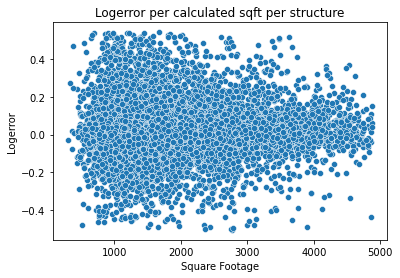

In [18]:
# What is the interaction of the variable with the target (Bivariate)
sns.scatterplot(x= 'calculatedfinishedsquarefeet', y='logerror', data=train)
plt.title('Logerror per calculated sqft per structure')
plt.xlabel('Square Footage') 
plt.ylabel('Logerror')
plt.show()

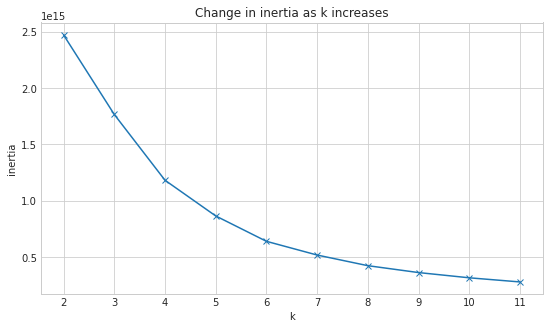

In [61]:
# let's add some clusters, first, let's figure out the adequate k number:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 5))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

- it looks like the adequate number of clusters is 5 based on the elbow method.

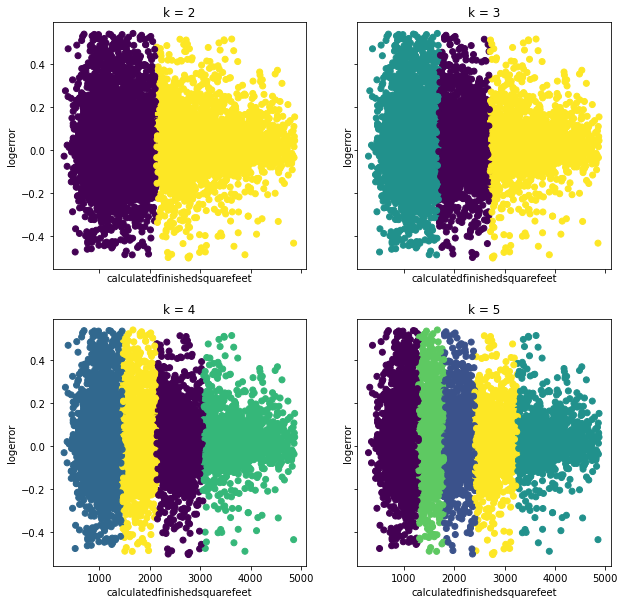

In [66]:
# it looks like k = 5 is ideal

cluster_one = train[['logerror', 'calculatedfinishedsquarefeet']]
kmeans = KMeans(n_clusters = 5)
kmeans.fit(cluster_one)

fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharex = True, sharey = True)

for ax, k in zip(axs.ravel(), range(2, 6)):
    clusters = KMeans(k).fit(cluster_one).predict(cluster_one)
    ax.scatter(cluster_one.calculatedfinishedsquarefeet, cluster_one.logerror, c = clusters)
    ax.set(title='k = {}'.format(k), ylabel = 'logerror', xlabel = 'calculatedfinishedsquarefeet')

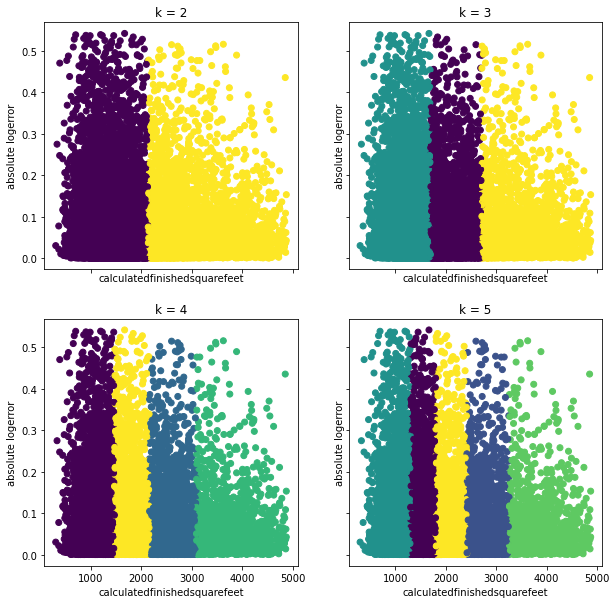

In [68]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharex = True, sharey = True)

for ax, k in zip(axs.ravel(), range(2, 6)):
    clusters = KMeans(k).fit(cluster_one).predict(cluster_one)
    ax.scatter(cluster_one.calculatedfinishedsquarefeet, abs(cluster_one.logerror), c = clusters)
    ax.set(title='k = {}'.format(k), ylabel = 'absolute logerror', xlabel = 'calculatedfinishedsquarefeet')

#### Takeaways
 - We can see a trend as square feet increases:
     - As square feet increases, the value of logerror starts being closer to zero in comparison with square footage of 0 to around 2500.
 - Also worth pointing out that although the optimal number of clusters for this visualization was 5 per the elbow method, it is interesting to see that as the number of clusters increase, the most right hand cluster is slowly being peeled away.

### Question 4

- How different are the logerrors for the three counties in the dataset?

In [122]:
## add a column that bins each value of logerror into max, min, or med absolute error
train['log_error'] = pd.cut(train.logerror, bins=[-.75, -.03, -.01, .01, .03, .75], ordered=False, labels=['max_error','med_error','min_error','med_error','max_error'])

# plot the data to see if any county has a higher percentage of max logerrors
x, y, hue = 'county', 'proportion', 'log_error'
hue_order = ['max_error', 'med_error', 'min_error']

plt.figure(figsize=(10,6))
(train[hue]
 .groupby(train[x])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, 'data'), x=train.county, y=train.proportion, hue= train.logerror))
plt.title('Orange County Has The Largest Proportion of Zestimate Max Error,\n Los Angeles Has The Smallest Proportion of Zestimate Minimum Error', size=15);
train.drop(columns = 'log_error', inplace = True)

AttributeError: 'DataFrame' object has no attribute 'proportion'

<Figure size 720x432 with 0 Axes>

In [ ]:
#train['proportion'] = 

# need to ask cristine how feature proportion was calculated

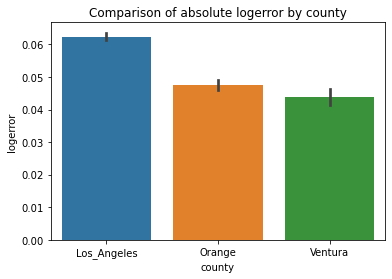

In [133]:
# let's do a visualization of logerror by county
sns.barplot(data = train, x = 'county', y = abs(train.logerror))
plt.title('Comparison of absolute logerror by county');

#### ANOVA Statistical Test: comparing means of logerror by county

**Set Hypothesis**

$H_{0}$: Logerror is not different for each different county

$H_{a}$: Logerror is different for each county

**Verify Assumptions**
 - Normal Distribution? **yes**
 - Independent Samples? **yes**
 - Equal Variances? **yes**

In [126]:
la_county_le = train[train.county == 'Los_Angeles'].logerror
orange_county_le = train[train.county == 'Ventura'].logerror
ventura_county_le = train[train.county == 'Orange'].logerror

#### Normal Distribution Check

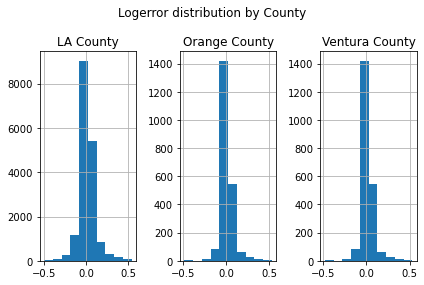

In [128]:
plt.suptitle('Logerror distribution by County')
plt.subplot(1,3,1)
la_county_le.hist()
plt.title('LA County')
plt.subplot(1,3,2)
orange_county_le.hist()
plt.title('Orange County')
plt.subplot(1,3,3)
orange_county_le.hist()
plt.title('Ventura County')
plt.tight_layout();

#### Variance Check

In [129]:
print('Variance values by County:')
print('LA County: ', la_county_le.var())
print('Orange County:', orange_county_le.var())
print('Ventura County', ventura_county_le.var())

Variance values by County:
LA County:  0.01001348140190564
Orange County: 0.005155953096185571
Ventura County 0.006207670922308004


In [130]:
f, p = stats.f_oneway(la_county_le, orange_county_le, ventura_county_le)
f, p

if p < alpha:
    print("We reject $H_{0}$")
else:
    print("We fail to reject $H_{0}$")

We reject $H_{0}$


#### Takeaways
 - The anova statistical test shows that each county does have a different logerror, as expected.
 - The absolute value of logerror barplot shows that although not by much, Ventura county has the lowest logerror number meaning that the zestimate tends to be correct more often for Ventura county.

## Scale

In [209]:
train_sc = train.drop(columns = ['county'])
validate_sc = validate.drop(columns = ['county'])
test_sc = test.drop(columns = ['county'])
num_cols = list(train_sc.columns)

# scaling
scaler = StandardScaler()

train_sc[num_cols] = scaler.fit_transform(train_sc[num_cols])
validate_sc[num_cols] = scaler.transform(validate_sc[num_cols])
test_sc[num_cols] = scaler.transform(test_sc[num_cols])

# adding back county column
train_sc = pd.concat([train_sc, train.county], axis = 1)
validate_sc = pd.concat([validate_sc, validate.county], axis = 1)
test_sc = pd.concat([test_sc, test.county], axis = 1)

# encode county column
train_sc = pd.concat([train_sc, pd.get_dummies(train_sc.county, drop_first = False)], axis = 1)
validate_sc = pd.concat([validate_sc, pd.get_dummies(validate_sc.county, drop_first = False)], axis =1)
test_sc = pd.concat([test_sc, pd.get_dummies(test_sc.county, drop_first = False)], axis = 1)

# dropping county column
train_sc.drop(columns = ['county'], inplace = True)
validate_sc.drop(columns = ['county'], inplace = True)
test_sc.drop(columns = ['county'], inplace = True)

# Model

In [222]:
X_train = train_sc.drop(columns=['logerror'])
y_train = pd.DataFrame(abs(train_sc.logerror))

X_validate = validate_sc.drop(columns=['logerror'])
y_validate = pd.DataFrame(abs(validate_sc.logerror))

X_test = test_sc.drop(columns=['logerror'])
y_test = pd.DataFrame(abs(test_sc.logerror))

In [213]:
y_train

,logerror
3446,1.047668
40895,0.183025
8023,0.189152
29716,1.163946
13805,0.966156
...,...
9968,0.334412
6719,1.793761
14988,0.294330
41858,0.520791


#### Baseline

In [215]:
# baseline:
baseline = X_train
baseline['pred_mean'] = abs(y_train.logerror).mean()
baseline['pred_median'] = abs(y_train.logerror).median()

In [217]:
# calculate baseline accuracy

rmse_baseline = mean_squared_error(abs(y_train.logerror), baseline.pred_mean)**(1/2)
print("RMSE using Mean\nBaseline: ", round(rmse_baseline, 3))

rmse_baseline = mean_squared_error(abs(y_train.logerror), baseline.pred_median)**(1/2)
print("RMSE using Median\nBaseline: ", round(rmse_baseline, 3))

RMSE using Mean
Baseline:  0.791
RMSE using Median
Baseline:  0.835


### Models
#### Linear Regression

In [241]:
# feature selection
lrm = LinearRegression()
rfe = RFE(lrm, n_features_to_select = 1)

rfe.fit(X_train, y_train)

rfe_columns = X_train.columns[rfe.support_].tolist()
print('The best feature is: ', rfe_columns)

The best feature is:  ['Los_Angeles']


In [242]:
def show_features_rankings(X_train, rfe):
    """
    Takes in a dataframe and a fit RFE object in order to output the rank of all features
    """
    var_ranks = rfe.ranking_
    var_names = X_train.columns.tolist()
    ranks = pd.DataFrame({'Var': var_names, 'Rank': var_ranks})
    ranks = ranks.sort_values(by = "Rank", ascending = True)
    return ranks

ranks = show_features_rankings(X_train, rfe)
ranks.head()

,Var,Rank
15,Los_Angeles,1
17,Ventura,2
14,censustractandblock,3
6,rawcensustractandblock,4
16,Orange,5


In [243]:
# OLS

ols = LinearRegression(normalize = True)

ols.fit(X_train, y_train.logerror)

y_train['pred_ols'] = ols.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.pred_ols)**(1/2)

# predict validate
y_validate['pred_ols'] = ols.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.pred_ols)**(1/2)

In [244]:
print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.7753373647201312 
Validation/Out-of-Sample:  0.7819303457874873


In [245]:
# lassolars

lasso = LassoLars(alpha = 1.0)

lasso.fit(X_train, y_train.logerror)

y_train['pred_lasso'] = lasso.predict(X_train)

rmse_train = mean_squared_error(y_train.logerror, y_train.pred_lasso)**(1/2)

y_validate['pred_lasso'] = lasso.predict(X_validate)

rmse_validate = mean_squared_error(y_validate.logerror, y_validate.pred_lasso)**(1/2)

In [246]:
print("RMSE for Lasso + Lars - alpha = 1.0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars - alpha = 1.0
Training/In-Sample:  0.7907939729836988 
Validation/Out-of-Sample:  0.7948689305564007


In [247]:
lasso = LassoLars(alpha = 2.0)

lasso.fit(X_train, y_train.logerror)

y_train['pred_lasso2'] = lasso.predict(X_train)

rmse_train = mean_squared_error(y_train.logerror, y_train.pred_lasso2)**(1/2)

y_validate['pred_lasso2'] = lasso.predict(X_validate)

rmse_validate = mean_squared_error(y_validate.logerror, y_validate.pred_lasso2)**(1/2)

In [248]:
print("RMSE for Lasso + Lars - alpha = 2.0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars - alpha = 2.0
Training/In-Sample:  0.7907939729836988 
Validation/Out-of-Sample:  0.7948689305564007


In [249]:
lasso = LassoLars(alpha = 3.0)

lasso.fit(X_train, y_train.logerror)

y_train['pred_lasso3'] = lasso.predict(X_train)

rmse_train = mean_squared_error(y_train.logerror, y_train.pred_lasso3)**(1/2)

y_validate['pred_lasso3'] = lasso.predict(X_validate)

rmse_validate = mean_squared_error(y_validate.logerror, y_validate.pred_lasso3)**(1/2)

In [250]:
print("RMSE for Lasso + Lars\ - alpha = 3.0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars\ - alpha = 3.0
Training/In-Sample:  0.7907939729836988 
Validation/Out-of-Sample:  0.7948689305564007


In [266]:
# TweedieRegressor (GLM)

glm = TweedieRegressor(power = 1, alpha = 0)

glm.fit(X_train, y_train.logerror)

y_train['pred_glm'] = glm.predict(X_train)

rmse_train = mean_squared_error(y_train.logerror, y_train.pred_glm)**(1/2)

# predict validate
y_validate['pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.pred_glm)**(1/2)

In [267]:
print("RMSE for GLM using Tweedie, power = 1 & alpha = 0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power = 1 & alpha = 0
Training/In-Sample:  0.7754696398289741 
Validation/Out-of-Sample:  0.782354163856343


In [268]:
glm = TweedieRegressor(power = 1, alpha = .05)

glm.fit(X_train, y_train.logerror)

y_train['pred_glm_pa'] = glm.predict(X_train)

rmse_train = mean_squared_error(y_train.logerror, y_train.pred_glm_pa)**(1/2)

# predict validate
y_validate['pred_glm_pa'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.pred_glm_pa)**(1/2)

In [269]:
print("RMSE for GLM using Tweedie, power = 1 & alpha = 0.05\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power = 1 & alpha = 0.05
Training/In-Sample:  0.775660362229552 
Validation/Out-of-Sample:  0.7822738726673661


In [255]:
# polynomial

pf = PolynomialFeatures(degree = 2)

X_train_degree2 = pf.fit_transform(X_train)

X_validate_degree2 = pf.transform(X_validate)

#X_test_degree3 = pf.transform(X_test)

lm2 = LinearRegression(normalize = True)

lm2.fit(X_train_degree2, y_train.logerror)

y_train['pred_lm2'] = lm2.predict(X_train_degree2)

rmse_train = mean_squared_error(y_train.logerror, y_train.pred_lm2)**(1/2)

y_validate['pred_lm2'] = lm2.predict(X_validate_degree2)

rmse_validate = mean_squared_error(y_validate.logerror, y_validate.pred_lm2)**(1/2)

In [256]:
print("RMSE for Polynomial Model, degrees = 2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees = 2
Training/In-Sample:  0.7645596783747517 
Validation/Out-of-Sample:  0.7774899210537994


In [257]:
pf = PolynomialFeatures(degree = 3)

X_train_degree3 = pf.fit_transform(X_train)

X_validate_degree3 = pf.transform(X_validate)

#X_test_degree3 = pf.transform(X_test)

lm3 = LinearRegression(normalize = True)

lm3.fit(X_train_degree3, y_train.logerror)

y_train['pred_lm3'] = lm3.predict(X_train_degree3)

rmse_train = mean_squared_error(y_train.logerror, y_train.pred_lm3)**(1/2)

y_validate['pred_lm3'] = lm3.predict(X_validate_degree3)

rmse_validate = mean_squared_error(y_validate.logerror, y_validate.pred_lm3)**(1/2)

In [258]:
print("RMSE for Polynomial Model, degrees = 3\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees = 3
Training/In-Sample:  0.747148606735296 
Validation/Out-of-Sample:  347898.52586916316


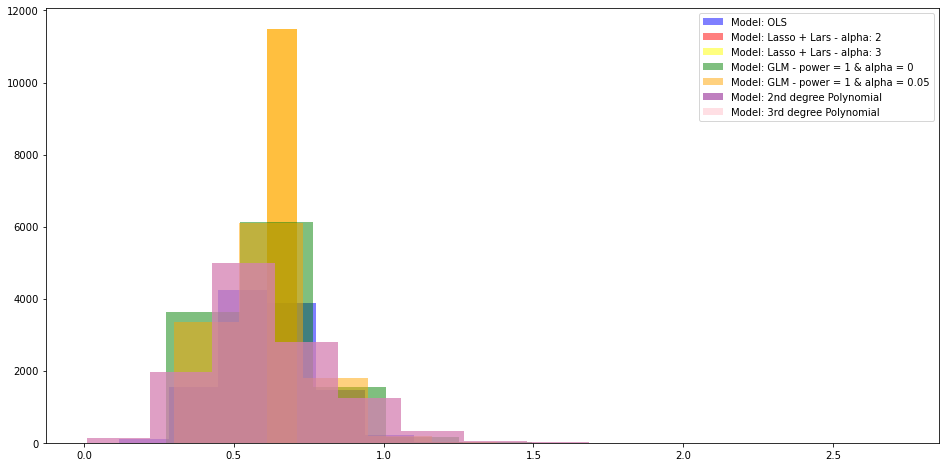

In [271]:
plt.figure(figsize=(16,8))
plt.hist(y_validate.pred_ols, color='blue', alpha=.5, label="Model: OLS")
plt.hist(y_validate.pred_lasso, color='red', alpha=.5, label="Model: Lasso + Lars - alpha: 2")
plt.hist(y_validate.pred_lasso3, color='yellow', alpha=.5, label="Model: Lasso + Lars - alpha: 3")
plt.hist(y_validate.pred_glm, color='green', alpha=.5, label="Model: GLM - power = 1 & alpha = 0")
plt.hist(y_validate.pred_glm_pa, color='orange', alpha=.5, label="Model: GLM - power = 1 & alpha = 0.05")
plt.hist(y_validate.pred_lm2, color='purple', alpha=.5, label="Model: 2nd degree Polynomial")
plt.hist(y_validate.pred_lm2, color='pink', alpha=.5, label="Model: 3rd degree Polynomial")
#plt.xlabel("Final Grade (G3)")
#plt.ylabel("Number of Students")
#plt.title("Comparing the Distribution of Actual Grades to Distributions of Predicted Grades for the Top Models")
plt.legend()
plt.show()

In [274]:
# polynomial

pf = PolynomialFeatures(degree = 2)

X_train_degree2 = pf.fit_transform(X_train)

X_validate_degree2 = pf.transform(X_validate)

X_test_degree2 = pf.transform(X_test)

lm2 = LinearRegression(normalize = True)

lm2.fit(X_train_degree2, y_train.logerror)

y_test['pred_lm2'] = lm2.predict(X_test_degree2)

rmse_test = mean_squared_error(y_test.logerror, y_test.pred_lm2)**(1/2)

In [275]:
print("RMSE for Polynomial Model, degrees = 2\nTraining/Test-Sample: ", rmse_train)

RMSE for Polynomial Model, degrees = 2
Training/Test-Sample:  0.775660362229552


# Conclusion & Next Steps

#### Takeaways:

- The best model was 2nd degree polynomial.

- x model had better accuracy than any other model

#### Next Steps / Recommendations:

- Ideally, look further into creating additional clusters that may improve the way the model was developed.
- Possibly take a different approach and do different models for each county.
- Create binne